<a href="https://colab.research.google.com/github/victorm0202/temas_selectos_DL/blob/main/imdb_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
keras.__version__

'2.6.0'

# CNN para clasificación de textos (F. Chollet)


## Implementing a 1D convnet

In Keras, you would use a 1D convnet via the `Conv1D` layer, which has a very similar interface to `Conv2D`. It takes as input 3D tensors 
with shape `(samples, time, features)` and also returns similarly-shaped 3D tensors. The convolution window is a 1D window on the temporal 
axis, axis 1 in the input tensor.

Let's build a simple 2-layer 1D convnet and apply it to the IMDB sentiment classification task that you are already familiar with.

As a reminder, this is the code for obtaining and preprocessing the data:

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
max_len = 500  # cut texts after this number of words (among top max_features most common words)

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
17473536/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)



1D convnets are structured in the same way as their 2D counter-parts: they consist of a stack of `Conv1D` 
and `MaxPooling1D` layers, eventually ending in either a global pooling layer or a `Flatten` layer, turning the 3D outputs into 2D outputs, allowing to add one or more `Dense` layers to the model, for classification or regression.

One difference, though, is the fact that we can afford to use larger convolution windows with 1D convnets. Indeed, with a 2D convolution layer, a 3x3 convolution window contains 3*3 = 9 feature vectors, but with a 1D convolution layer, a convolution window of size 3 would only contain 3 feature vectors. We can thus easily afford 1D convolution windows of size 7 or 9.

This is our example 1D convnet for the IMDB dataset:

In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
____________________________________________

In [ ]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 34s 23ms/step - loss: 0.7535 - acc: 0.5267 - val_loss: 0.6844 - val_acc: 0.5620
Epoch 2/10
157/157 [==============================] - 3s 20ms/step - loss: 0.6632 - acc: 0.6697 - val_loss: 0.6648 - val_acc: 0.6022
Epoch 3/10
157/157 [==============================] - 3s 20ms/step - loss: 0.6167 - acc: 0.7643 - val_loss: 0.6070 - val_acc: 0.7360
Epoch 4/10
157/157 [==============================] - 3s 20ms/step - loss: 0.5213 - acc: 0.8157 - val_loss: 0.4863 - val_acc: 0.8056
Epoch 5/10
157/157 [==============================] - 3s 20ms/step - loss: 0.3975 - acc: 0.8535 - val_loss: 0.4184 - val_acc: 0.8330
Epoch 6/10
157/157 [==============================] - 3s 20ms/step - loss: 0.3363 - acc: 0.8791 - val_loss: 0.3934 - val_acc: 0.8500
Epoch 7/10
157/157 [==============================] - 3s 20ms/step - loss: 0.2942 - acc: 0.8974 - val_loss: 0.4052 - val_acc: 0.8602
Epoch 8/10
157/157 [==============================] - 3s 20ms/step -

Here are our training and validation results: validation accuracy is somewhat lower than that of the LSTM we used two sections ago, but 
runtime is faster, both on CPU and GPU (albeit the exact speedup will vary greatly depending on your exact configuration). At that point, 
we could re-train this model for the right number of epochs (8), and run it on the test set. This is a convincing demonstration that a 1D 
convnet can offer a fast, cheap alternative to a recurrent network on a word-level sentiment classification task.

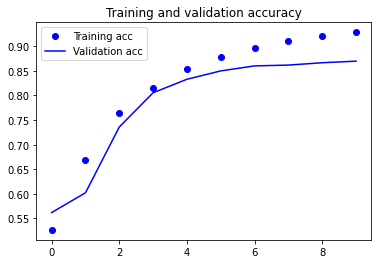

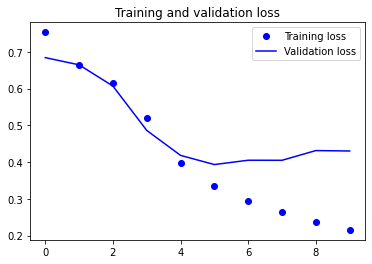

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()